In [87]:
import matplotlib.pyplot as plt
from astropy import *
import astropy.units as u
from astropy.io import fits
import numpy as np
import glob as glob
import pandas as pd
from astropy.table import Table,vstack,hstack

import subprocess
import sys
import os
import logging
import numpy as np


from scipy.interpolate import interp1d
import time
from astropy.stats import sigma_clip
import scipy
from scipy.interpolate import interp1d
from scipy import interpolate

In [96]:
# ! ls /uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/fits/old_files/galah/dr4/spectra/hermes/all/
spectra_path = '/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/fits/galah_dr4_cluster_fgk_m_spectra/'

candidates = Table.read('galah_candidate_cluster_members.fits')

In [97]:
filenames = glob.glob(spectra_path + '/*1.fits')

sobject_ids = []
gaia_id = []
snr = []
snr_per_pixel = []
for i in filenames:
    fitsname = i.split('/')[-1]
    sobj_id = int(fitsname.split('1.fits')[0])
    hdu = fits.open(i)
    header = hdu[0].header

    sobject_ids.append(int(header['GALAH_ID']))
    gaia_id.append(header['GAIA_ID'])
    snr.append(header['SNR'])
    snr_per_pixel.append(header['SNR_AA'])

sobject_ids = np.array(sobject_ids)

array([ True,  True, False, False, False, False,  True, False,  True,
       False, False, False,  True,  True, False,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False,  True,  True,  True, False,
        True,  True, False, False,  True, False,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
       False, False, False, False,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True, False, False,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
       False, False, False,  True, False,  True, False, False, False,
       False, False,

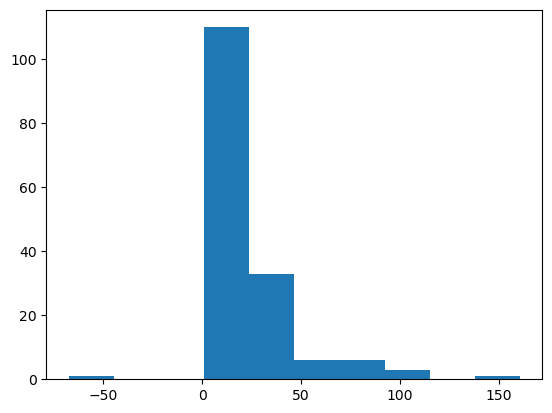

In [98]:
plt.hist(snr)
np.array(snr) > 10

In [5]:
# glob.glob('/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/fits/galah_dr4_cluster_fgk_m_spectra/{}1.fits'.format(150429003300262))

In [11]:
ispec_dir = '/uufs/astro.utah.edu/common/home/u1363702/iSpec'
sys.path.append(ispec_dir)

In [12]:
import ispec
def determine_radial_velocity_with_template(waves, fluxes):
    mu_cas_spectrum = Table([waves*.1, fluxes, np.repeat(0,len(fluxes))], names=('waveobs', 'flux', 'err'))
    #--- Radial Velocity determination with template -------------------------------
    #logging.info("Radial velocity determination with template...")
    # - Read synthetic template
    # template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/Atlas.Arcturus.372_926nm/template.txt.gz")
    template = ispec.read_spectrum(path + 'template.txt.gz')
    #template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/NARVAL.Sun.370_1048nm/template.txt.gz")
    #template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/Synth.Sun.300_1100nm/template.txt.gz")

    models, ccf = ispec.cross_correlate_with_template(mu_cas_spectrum, template, \
                            lower_velocity_limit=-200, upper_velocity_limit=200, \
                            velocity_step=1.0, fourier=False)

    # Number of models represent the number of components
    components = len(models)
    # First component:
    rv = np.round(models[0].mu(), 2) # km/s
    rv_err = np.round(models[0].emu(), 2) # km/s
    return rv, rv_err

In [27]:
path = '/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/fits/'
def get_spectra(obj_id):
    wavelengths = []
    fluxes = []
    uncertainties = []
    gaia_id = 0
    for i in range(1,5):
        try:
            pathway = '/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/fits/galah_dr4_cluster_fgk_m_spectra/{}{}.fits'.format(obj_id,i)
            hdu = fits.open(pathway)
            flux = hdu[1].data
            err = hdu[2].data * flux

            gaia_id = hdu[0].header['GAIA_ID']
            wave = []
            for j in range(len(flux)):
                lamda = hdu[1].header['CRVAL1'] + hdu[1].header['CDELT1']*j
                wave.append(lamda)
            wave = np.array(wave)
            wavelengths.append(wave)
            fluxes.append(flux)
            uncertainties.append(err**2)
        except:
            print('no HDU {} for {}'.format(i,obj_id))

    if len(wavelengths) > 0:
        wavelength = np.concatenate(wavelengths)
        flux = np.concatenate(fluxes)
        uncertainty = np.concatenate(uncertainties)

        rv, rv_err = determine_radial_velocity_with_template(wavelength, flux)
        corr_data = ispec.correct_velocity(Table([wavelength, flux, uncertainty], names=['waveobs','flux', 'err']), rv)

        waves = corr_data['waveobs']
        flux = corr_data['flux']
        flux_err = corr_data['err']

        data = np.dstack((waves,flux,flux_err))[0]

        star_id = '/galah_id_{}'.format(obj_id)

        filename = spectra_path+star_id + '.txt'
        np.savetxt(filename, data)
        return data, rv, rv_err
    else:
        return [0,0,0], 0, 0

In [63]:
data, rv, rv_err = get_spectra(sobject_ids[3])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True,  True,  True, False, False,  True,  True,  True,
        True, False,  True,  True, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False,  True, False,
       False,  True,  True, False,  True, False,  True, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False,  True, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

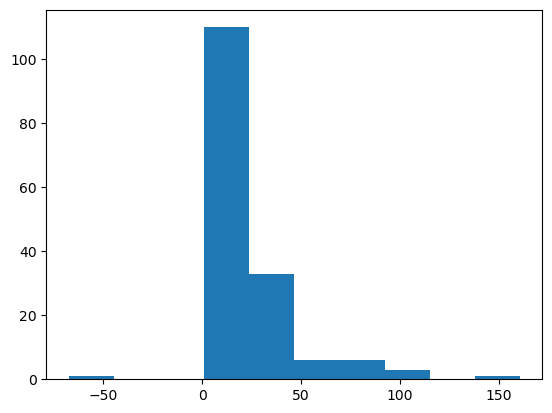

In [80]:
plt.hist(snr)
np.array(snr) > 30

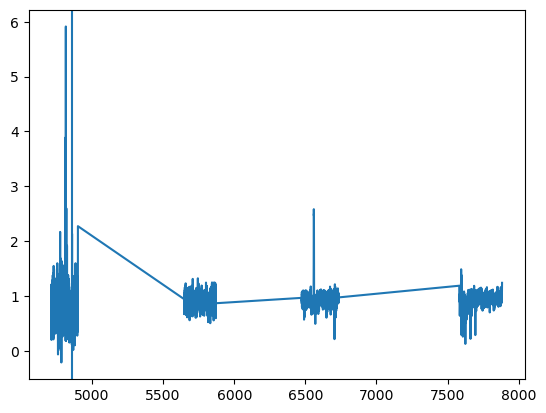

In [75]:
fig2 = plt.figure()
plt.errorbar(data[:,0], data[:,1])
plt.axvline(x=4861)
# plt.xlim(6600,6700)
# plt.ylim(0,1.5)

In [ ]:
ids = glob.glob(spectra_path + 'hermes/all/*1.fits')

In [ ]:
all_ids = []
for i in ids:
    ar = i.split('/')[-1]
    ar = ar.split('1.fits')[0]
    all_ids.append(ar)

In [ ]:
ids = glob.glob(spectra_path + 'hermes/com/*1.fits')

In [ ]:
com_ids = []
for i in ids:
    ar = i.split('/')[-1]
    ar = ar.split('1.fits')[0]
    com_ids.append(ar)

In [ ]:
print(len(com_ids), len(all_ids))

In [ ]:
fits_path = '/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/fits/'
galah = Table.read(fits_path + 'galah_dr4_allstar.fits')

In [ ]:
truth = np.isin(np.array(all_ids).astype(int), galah['gaiadr3_source_id'])
truth

In [ ]:
np.isin(140111003900031, galah['sobject_id'])

In [ ]:
f1 = '/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/fits/old_files/galah/dr4/spectra/hermes/all/{}{}.fits'.format(140111003900031,2)
hdu = fits.open(pathway)
flux = hdu[1].data
flux

In [ ]:
hdu[0].header

In [ ]:
hdu

In [ ]:
np.isin('140111003900031',galah['sobject_id']) 

In [ ]:
galah